In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="4"
import torch

import numpy as np
import imageio
import pprint
from time import time
from tqdm import tqdm, trange
from run_nerf_helpers import *

import matplotlib.pyplot as plt

import run_nerf
import load_blender

# General setup for GPU device and default tensor type.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_tensor_type('torch.cuda.FloatTensor')

### Load trained network weights
Note: this ipynb assumes a blender_paper_lego NeRF model is trained beforehand.

In [2]:
basedir = './logs'
expname = 'blender_paper_lego'

config = os.path.join(basedir, expname, 'config.txt')
print('Args:')
print(open(config, 'r').read())

parser = run_nerf.config_parser()

args = parser.parse_args('--config {}'.format(config))
args.n_gpus = torch.cuda.device_count()

# Create nerf model
render_kwargs_train, render_kwargs_test, start, grad_vars, optimizer = run_nerf.create_nerf(args)

bds_dict = {
    'near' : 2.0,
    'far' : 6.0,
}
render_kwargs_train.update(bds_dict)
render_kwargs_test.update(bds_dict)

# print('Render kwargs:')
# pprint.pprint(render_kwargs_test)

# net_fn = render_kwargs_test['network_query_fn']
# print(net_fn)

# Render an overhead view to check model was loaded correctly

# H, W, focal = 800, 800, 1200.
# down = 8
# up = 1
# nr = 2; nc = 2
# with torch.no_grad():
#     fig = plt.figure(figsize=(18,18))
#     axes = fig.subplots(nrows=nr, ncols=nc)
#     for i in range (nr*nc):
#         prevtime = time()
#         x = i//nr; y = i%nc
#         c2w = load_blender.pose_spherical(i*90-45., -30., 4.)
#         rgb, disp, _, _ = run_nerf.render(H//down*up, W//down*up, focal/down*up, c2w=c2w[:3, :4], **render_kwargs_test)

#         axes[x,y].imshow(np.clip(rgb.cpu().numpy(), 0.0, 1.0))
#         print("rendering time for ", H//down*up, " by ", W//down*up, ": ", time()-prevtime, " seconds")
#     plt.show()

Args:
expname = blender_paper_lego
basedir = ./logs
datadir = ./data/nerf_synthetic/lego
dataset_type = blender

no_batching = True

use_viewdirs = True
white_bkgd = True
lrate_decay = 500

N_samples = 64
N_importance = 128
N_rand = 1024

precrop_iters = 500
precrop_frac = 0.5

half_res = True

Found ckpts ['./logs/blender_paper_lego/010000.tar', './logs/blender_paper_lego/020000.tar', './logs/blender_paper_lego/030000.tar', './logs/blender_paper_lego/040000.tar', './logs/blender_paper_lego/050000.tar', './logs/blender_paper_lego/060000.tar', './logs/blender_paper_lego/070000.tar', './logs/blender_paper_lego/080000.tar', './logs/blender_paper_lego/090000.tar', './logs/blender_paper_lego/100000.tar', './logs/blender_paper_lego/110000.tar', './logs/blender_paper_lego/120000.tar', './logs/blender_paper_lego/130000.tar', './logs/blender_paper_lego/140000.tar', './logs/blender_paper_lego/150000.tar', './logs/blender_paper_lego/160000.tar', './logs/blender_paper_lego/170000.tar', './logs/ble

# initial Settings

In [3]:
# from load_llff import load_llff_data
# images, poses, bds, render_poses, i_test = load_llff_data("./data/nerf_synthetic/lego", args.factor, recenter=True, bd_factor=.75, spherify=args.spherify)

from load_blender import load_blender_data
images, poses, render_poses, hwf, i_split = load_blender_data("./data/nerf_synthetic/lego", False, 8)
H, W, focal = hwf[0], hwf[1], hwf[2]

[[ 7.6567030e-01 -4.7312441e-01  4.3577790e-01  1.7566769e+00]
 [ 6.4323324e-01  5.6318182e-01 -5.1872659e-01 -2.0910537e+00]
 [ 2.9802321e-08  6.7748034e-01  7.3554093e-01  2.9650602e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]


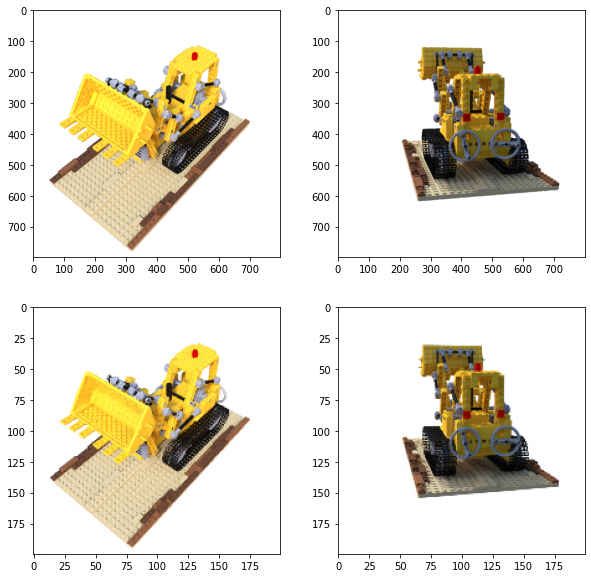

In [4]:
# show ground truth target pose and image
init_index = 26 # 63
target_index = 36 # 70
Targetpose = poses[target_index]
Targetrgb = images[target_index]; Targetrgb[Targetrgb[...,3]==0.]=1.0; Targetrgb = Targetrgb[...,0:3]
initrgb = images[init_index]; initrgb[initrgb[...,3]==0.]=1.0; initrgb = initrgb[...,0:3]
print(Targetpose)
fig1 = plt.figure(figsize=(10,10))
axes1 = fig1.subplots(nrows=2, ncols=2)
axes1[0,0].imshow(Targetrgb)
axes1[0,1].imshow(initrgb)
# Hidx, Widx = np.random.choice(np.arange(H//down), size=1000), np.random.choice(np.arange(W//down), size=1000)
#### render
with torch.no_grad():
    sampledown = 4
    target_render, _, _, _ = run_nerf.render(H//sampledown, W//sampledown, focal/sampledown, c2w=torch.from_numpy(poses[target_index, :3, :4]).cuda(), **render_kwargs_test)
    axes1[1,0].imshow(np.clip(target_render.detach().cpu().numpy(),  0.0, 1.0))
    init_render, _, _, _ = run_nerf.render(H//sampledown, W//sampledown, focal/sampledown, c2w=torch.from_numpy(poses[init_index, :3, :4]).cuda(), **render_kwargs_test)
    axes1[1,1].imshow(np.clip(init_render.detach().cpu().numpy(),  0.0, 1.0))
plt.show()

#### MSE
# with torch.no_grad():
#     sampledown = 4
#     target_render, _, _, _ = run_nerf.render(H//sampledown, W//sampledown, focal/sampledown, c2w=torch.from_numpy(poses[target_index, :3, :4]).cuda(), **render_kwargs_test, Hidx=Hidx, Widx=Widx)
#     init_render, _, _, _ = run_nerf.render(H//sampledown, W//sampledown, focal/sampledown, c2w=torch.from_numpy(poses[init_index, :3, :4]).cuda(), **render_kwargs_test, Hidx=Hidx, Widx=Widx)
# print("Target: ", np.mean((Targetrgb[Hidx,Widx,0:3]-target_render.detach().cpu().numpy())**2))
# print("Init: ", np.mean((initrgb[Hidx,Widx,0:3]-init_render.detach().cpu().numpy())**2))

In [5]:
for param in grad_vars:
    param.requires_grad = False

for param in render_kwargs_test['network_fn'].parameters():
    param.requires_grad = False

for param in render_kwargs_test['network_fine'].parameters():
    param.requires_grad = False

In [20]:
# render NeRF network at Target view 
N_rand = args.N_rand
use_batching = False #not args.no_batching

mse = torch.nn.MSELoss()
initpose = torch.tensor(poses[init_index]).to(device)
# learn_trans = torch.cat((torch.zeros(6).to(device).requires_grad_(True), torch.ones(1).to(device).requires_grad_(True))) # w(3), v(3)
learn_rot = torch.zeros(3).to(device).requires_grad_(True) # w(3), v(3)
learn_trl = torch.zeros(3).to(device).requires_grad_(True) # w(3), v(3)
theta = torch.ones(1).to(device).requires_grad_(True) # w(3), v(3)
learn_trans = torch.cat((learn_rot, learn_trl, theta))
Targetrgb = torch.tensor(Targetrgb).to(device)
Targetpose = torch.tensor(Targetpose).to(device)

def get_translated_pose(initpose, learn_trans): # 4x4, 1x6
    
    if 1:
        w = torch.zeros(3,3).to(learn_trans.device)
        theta = learn_trans[6]
        wnorm = 1 if torch.norm(learn_trans[0:3])==0 else torch.norm(learn_trans[0:3])
        w[0,1] = -learn_trans[2]/wnorm
        w[1,0] = learn_trans[2]/wnorm
        w[0,2] = learn_trans[1]/wnorm
        w[2,0] = -learn_trans[1]/wnorm
        w[1,2] = -learn_trans[0]/wnorm
        w[2,1] = learn_trans[0]/wnorm
        R = torch.matrix_exp(w*theta) # ^c1_c2{R}

        v = learn_trans[3:6].reshape(3,1)
        transform_pose = torch.zeros(4, 4).to(learn_trans.device)
        transform_pose[0:3,0:3] = R
        # transform_pose[0:3,-1] = theta*v.squeeze() + (1-torch.cos(theta))*torch.matmul(w,v).squeeze() + (theta-torch.sin(theta))*torch.matmul(torch.matmul(w,w),v).squeeze()
        # transform_pose[0:3,-1] = v.squeeze() + (torch.sin(theta))*torch.matmul(w,v).squeeze() + (1-torch.cos(theta))*torch.matmul(torch.matmul(w,w),v).squeeze()
        mat1 = (torch.eye(3) * theta) - (1 - torch.cos(theta) * w) + ((theta - torch.sin(theta)) * torch.matmul(w, w))
        mat2 = torch.matmul(mat1, v).squeeze()
        transform_pose[0:3,-1] = mat2
        transform_pose[3,3] = 1
        newpose = torch.matmul(transform_pose, initpose)

    if 0:
        w = torch.zeros(3,3).to(learn_trans.device)
        theta = learn_trans[6]
        wnorm = 1 if torch.norm(learn_trans[0:3])==0 else torch.norm(learn_trans[0:3])
        w[0,1] = -learn_trans[2]/wnorm
        w[1,0] = learn_trans[2]/wnorm
        w[0,2] = learn_trans[1]/wnorm
        w[2,0] = -learn_trans[1]/wnorm
        w[1,2] = -learn_trans[0]/wnorm
        w[2,1] = learn_trans[0]/wnorm
        R = torch.matrix_exp(w*theta) # ^c1_c2{R}

        v = learn_trans[3:6].reshape(3,1)
        transform_pose = torch.zeros(4, 4).to(learn_trans.device)
        transform_pose[0:3,0:3] = R
        # transform_pose[0:3,-1] = theta*v.squeeze() + (1-torch.cos(theta))*torch.matmul(w,v).squeeze() + (theta-torch.sin(theta))*torch.matmul(torch.matmul(w,w),v).squeeze()
        # transform_pose[0:3,-1] = v.squeeze() + (torch.sin(theta))*torch.matmul(w,v).squeeze() + (1-torch.cos(theta))*torch.matmul(torch.matmul(w,w),v).squeeze()
        transform_pose[0:3,-1] = v.squeeze()
        transform_pose[3,3] = 1
        newpose = torch.matmul(transform_pose, initpose)

    if 0:
        R = torch.zeros(3,3).to(learn_trans.device)
        R[0,1] = -learn_trans[2]
        R[1,0] = learn_trans[2]
        R[0,2] = learn_trans[1]
        R[2,0] = -learn_trans[1]
        R[1,2] = -learn_trans[0]
        R[2,1] = learn_trans[0]
        R = torch.matrix_exp(R)#*learn_trans[6]) # ^c1_c2{R}
        newpose = torch.zeros(4, 4).to(learn_trans.device)
        newpose[0:3,0:3] = torch.matmul(initpose[0:3,0:3], R) # ^w_c2{R} = ^w_c1{R} * ^c1_c2{R}
        newpose[0:3,-1] = torch.matmul(initpose[0:3,0:3], learn_trans[3:6].reshape(3,1)).squeeze() + initpose[0:3,-1] # ^w{p}_c2org = ^w{p}_c1org + ^w_c1{R} * ^c1{p}_c2org
        newpose[3,3] = 1

    if 0:
        R = torch.zeros(3,3).to(learn_trans.device)
        R[0,1] = -learn_trans[2]
        R[1,0] = learn_trans[2]
        R[0,2] = learn_trans[1]
        R[2,0] = -learn_trans[1]
        R[1,2] = -learn_trans[0]
        R[2,1] = learn_trans[0]
        R = torch.matrix_exp(R) # ^c1_c2{R}
        newpose = torch.zeros(4, 4).to(learn_trans.device)
        newpose[0:3,0:3] = torch.matmul(R, initpose[0:3,0:3])#
        newpose[0:3,-1] = torch.matmul(R, initpose[0:3,-1].reshape(3,1)).squeeze() + learn_trans[3:6] #
        newpose[3,3] = 1

    return newpose

with torch.no_grad():
    print("init: \n", initpose)
    newpose = get_translated_pose(initpose, learn_trans)
    print(newpose)
    print(torch.equal(newpose, initpose))

init: 
 tensor([[-9.7526e-01, -3.9201e-02,  2.1757e-01,  8.7705e-01],
        [ 2.2107e-01, -1.7293e-01,  9.5980e-01,  3.8691e+00],
        [ 3.7253e-09,  9.8415e-01,  1.7732e-01,  7.1480e-01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])
tensor([[-9.7526e-01, -3.9201e-02,  2.1757e-01,  8.7705e-01],
        [ 2.2107e-01, -1.7293e-01,  9.5980e-01,  3.8691e+00],
        [ 3.7253e-09,  9.8415e-01,  1.7732e-01,  7.1480e-01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])
True
<ipython-input-20-346792fb0a62>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Targetrgb = torch.tensor(Targetrgb).to(device)
<ipython-input-20-346792fb0a62>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torc

# Step1 

## Get better initial pose using SuperGlue (feature matching)

이 부분을 쓰시려면 SuperGluePretrainedNetwork를 이 파일이 있는 경로에 clone해주세요 (submodule 해놨긴 했습니다만...)

In [8]:
import json
with open(os.path.join("./data/nerf_synthetic/lego", 'transforms_test.json'), 'r') as fp:
    meta_test = json.load(fp)

In [9]:
import numpy as np
inittest_poses = []
inittest_rendered = []
for ii in [0,25,50,75,100,125,150,175]:
    inittest_poses.append(np.array(meta_test['frames'][ii]['transform_matrix']))

### 이 아래 cell 시간 많이 걸립니다 (대략 5분)
down을 키우면 (1,2,4,8) 적게 걸립니다.

In [15]:
down = 1
from time import time
prevtime = time()
with torch.no_grad():
    for ii in range(len(inittest_poses)):
        rgb, disp, _, _ = run_nerf.render(H//down, W//down, focal/down, c2w=torch.tensor(inittest_poses[ii][:3, :4]).to(device), **render_kwargs_test)
        inittest_rendered.append(rgb.detach().cpu().numpy())
    print(time()-prevtime)

14.716698169708252


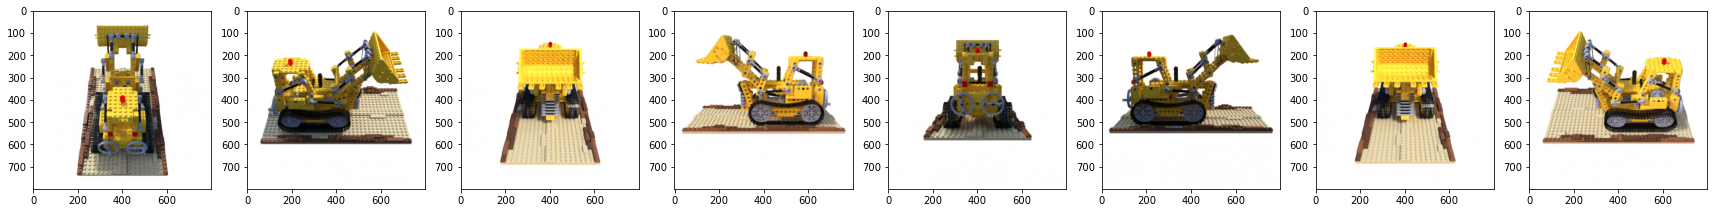

In [11]:
fig1 = plt.figure(figsize=(30,30))
axes1 = fig1.subplots(nrows=1, ncols=8)
for ii in range(8):
    axes1[ii].imshow(np.clip(inittest_rendered[ii], 0., 1.))

# Meta data load

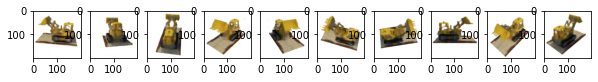

In [22]:
import numpy as np
import cv2
inittest_poses = []
inittest_rendered = []
down = 4 

fig1 = plt.figure(figsize=(10,30))
axes1 = fig1.subplots(nrows=1, ncols=10)
for ii in range(10):
    inittest_rendered.append(cv2.resize(imageio.imread("metalego"+str(ii)+".png").astype(np.float32)[...,0:3]/255., dsize=(800//down, 800//down), interpolation=cv2.INTER_AREA))
    axes1[ii].imshow(np.clip(inittest_rendered[ii], 0., 1.))

inittest_poses = np.load("metasaveposes.npy")

In [16]:
from SuperGluePretrainedNetwork.models.matching import Matching
from SuperGluePretrainedNetwork.models.utils import frame2tensor, make_matching_plot_fast, estimate_pose
import cv2
import matplotlib.cm as cm

config = {
    'superpoint': {
        'nms_radius': 4,
        'keypoint_threshold': 0.005,
        'max_keypoints': -1
    },
    'superglue': {
        'weights': 'indoor',
        'sinkhorn_iterations': 20,
        'match_threshold': 0.2,
    }
}
matching = Matching(config).eval().to(device)
keys = ['keypoints', 'scores', 'descriptors']

frame = cv2.cvtColor(Targetrgb.detach().cpu().numpy(), cv2.COLOR_RGB2GRAY)
frame = cv2.resize(frame, dsize=(frame.shape[0]//down, frame.shape[1]//down), interpolation=cv2.INTER_AREA)
frame_tensor = torch.from_numpy(frame[None,None]).to(device)
last_data = matching.superpoint({'image': frame_tensor})
last_data = {k+'0': last_data[k] for k in keys}
last_data['image0'] = frame_tensor
last_frame = frame

Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)


In [18]:
prevtime = time()
valid_maxnum = 0
for ii in range(8):
    frame_tensor = torch.from_numpy(cv2.cvtColor(inittest_rendered[ii], cv2.COLOR_RGB2GRAY)[None,None]).to(device)
    pred = matching({**last_data, 'image1': frame_tensor})
    matches = pred['matches0'][0].detach().cpu().numpy()
    valid = matches > -1

    if valid.sum() > valid_maxnum and not ii==3:
        valid_maxnum = valid.sum()
        best_index = ii
        print("index: ", best_index, " / valid_feat: ", valid_maxnum)
        best_frame = cv2.cvtColor(inittest_rendered[ii], cv2.COLOR_RGB2GRAY)
        kpts0 = last_data['keypoints0'][0].detach().cpu().numpy()
        kpts1 = pred['keypoints1'][0].detach().cpu().numpy()
        confidence = pred['matching_scores0'][0].detach().cpu().numpy()
        mkpts0 = kpts0[valid]
        mkpts1 = kpts1[matches[valid]]
        mconf = confidence[valid]
        
        color = cm.jet(confidence[valid])
        text = [
            'SuperGlue',
            'Keypoints: {}:{}'.format(len(kpts0), len(kpts1)),
            'Matches: {}'.format(len(mkpts0))
        ]
        k_thresh = matching.superpoint.config['keypoint_threshold']
        m_thresh = matching.superglue.config['match_threshold']
        small_text = [
            'Keypoint Threshold: {:.4f}'.format(k_thresh),
            'Match Threshold: {:.2f}'.format(m_thresh),
        ]        

print(time()-prevtime)

index:  0  / valid_feat:  30
5.897463798522949


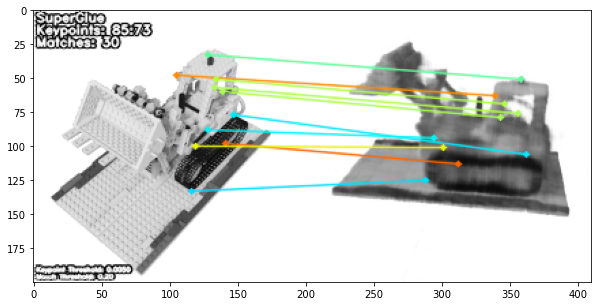

In [19]:
# Left: Target / right: reference init-view
conf_thres = 0.5
out = make_matching_plot_fast(last_frame*255., best_frame*255., kpts0, kpts1, mkpts0[mconf>conf_thres,:], mkpts1[mconf>conf_thres,:], color, text, path=None, show_keypoints=False, small_text=small_text)
fig2 = plt.figure(figsize=(10,10))
plt.imshow(out)

# Step 2
## superglue -> essential -> R,T
Using initial pose from step 1 & Using location of feature points for `Hidx` and `Widx`

In [31]:
initpose = torch.tensor(inittest_poses[best_index].astype(np.float32)).to(device) # 위에서 고른 best_index에 맞는 pose를 initpose로

In [34]:
from SuperGluePretrainedNetwork.models.utils import frame2tensor, make_matching_plot_fast, estimate_pose, rotate_intrinsics, scale_intrinsics

conf_thres = 0.0
K = np.zeros((3,3))
K[0,0] = hwf[2]/down
K[1,1] = hwf[2]/down
K[0,2] = H/down/2
K[1,2] = W/down/2
ret = estimate_pose(mkpts0[mconf>conf_thres,:], mkpts1[mconf>conf_thres,:], K, K, 1.) #

## Note
`estimate_pose`에서 나온 T는 cam1_T_cam0인거 같고 (match_pairs.py 참고)

제가 알기로는 initpose, targetpose가 World_T_cam이라고 알고 있었는데, transformation을 잘못한건지 알고있던 frame이 틀린건지 모르겠네요

[[-0.26108051  0.18586069 -0.94725528  4.59259182]
 [-0.93788065 -0.28113031  0.20333624  0.30412161]
 [-0.22850996  0.94149964  0.24771287  1.68929926]
 [ 0.          0.          0.          1.        ]]
tensor([[ 7.6567e-01, -4.7312e-01,  4.3578e-01,  1.7567e+00],
        [ 6.4323e-01,  5.6318e-01, -5.1873e-01, -2.0911e+00],
        [ 2.9802e-08,  6.7748e-01,  7.3554e-01,  2.9651e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])


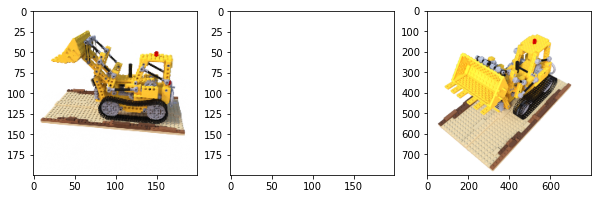

In [35]:
T = np.zeros((4,4))
T[0:3,0:3] = ret[0]
T[0:3,3] = ret[1]
T[3,3] = 1.

# newT = torch.from_numpy(np.matmul(T, initpose.detach().cpu().numpy())).to(device)
# newT = np.linalg.inv(T) @ initpose.detach().cpu().numpy()
newT = initpose.detach().cpu().numpy() @ T # world_T_target = world_T_init * init_T_target을 의도함

print(newT)
print(Targetpose)

with torch.no_grad():
    fig = plt.figure(figsize=(10,30))
    axes = fig.subplots(nrows=1, ncols=3)

    rgb1, disp, _, _ = run_nerf.render(H//4, W//4, focal/4, c2w=initpose[:3, :4], **render_kwargs_test)
    axes[0].imshow(np.clip(rgb1.detach().cpu().numpy(), 0., 1.))

    rgb2, disp, _, _ = run_nerf.render(H//4, W//4, focal/4, c2w=torch.from_numpy(newT[:3, :4]).to(device), **render_kwargs_test)
    axes[1].imshow(np.clip(rgb2.detach().cpu().numpy(), 0., 1.))

    axes[2].imshow(np.clip(Targetrgb.detach().cpu().numpy(), 0., 1.))

# Another Step

## 기존의 iNeRF 코드 + sampling하는 위치를 feature 뽑는 곳으로 설정해봄

In [25]:
initpose = torch.tensor(inittest_poses[best_index].astype(np.float32)).to(device)

# feature를 sampling하는 위치로
conf_thres = 0.6
Hidx, Widx = torch.from_numpy(mkpts0[mconf>conf_thres,0].astype(np.long)), torch.from_numpy(mkpts0[mconf>conf_thres,1].astype(np.long))

# interesting region - 
oHidx, oWidx = Hidx, Widx
for i in [-1,0,1]:
    for j in [-1,0,1]:
        if i==0 and j==0:
            continue
        oHidx, oWidx = torch.cat((oHidx, Hidx+i)), torch.cat((oWidx, Widx+j))

## 아래 코드에서 Hidx, Widx 대신 oHidx, oWidx 쓰시면 feature 위치를 사용 (`if 1:` 내부 확인)

In [26]:
N_iters = 100
step = 100
down = 1
sampledown = 4 # only for video generation
sN = 1024*6 
# optim = torch.optim.Adam(params=[learn_trans], lr=1e-2, betas=(0.9, 0.999))
optim = torch.optim.Adam([{'params':learn_trl ,'lr':1e-2}, {'params':learn_rot ,'lr':5e-2}, {'params':theta ,'lr':1e-2}], betas=(0.9, 0.999))
# optim_rot = torch.optim.Adam(params=[learn_trl], lr=1e-1, betas=(0.9, 0.999))
opt_scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, 0.998)
posesave = []
losssave = []
renderpath = "./iNeRFrender23_updateruletest"
os.makedirs(renderpath, exist_ok=True)
# curr_trans = learn_trans*0.001

for i in trange(N_iters):
    optim.zero_grad()
    learn_trans = torch.cat((learn_rot, learn_trl, theta))
    newpose = get_translated_pose(initpose, learn_trans)
    if 1:#i==0:
        Hidx, Widx = torch.from_numpy(np.random.choice(np.arange(H//down), size=sN)).to(device), torch.from_numpy(np.random.choice(np.arange(W//down), size=sN)).to(device)
        # Hidx, Widx = torch.from_numpy(mkpts0[:,0].astype(np.long)), torch.from_numpy(mkpts0[:,1].astype(np.long))
        # Hidx, Widx = oHidx, oWidx
    else:
        with torch.no_grad():
            bestidx = torch.argsort(torch.sum((rgbest-Targetrgb[Hidx, Widx, 0:3])**2, dim=-1), descending=True).to(device)
        newHidx, newWidx = torch.from_numpy(np.random.choice(np.arange(H//down), size=sN-sN//2)).to(device), torch.from_numpy(np.random.choice(np.arange(W//down), size=sN-sN//2)).to(device)
        Hidx, Widx = torch.cat((Hidx[bestidx[:sN//2]], newHidx), dim=0), torch.cat((Widx[bestidx[:sN//2]], newWidx), dim=0)
        # with torch.no_grad():
        #     rgb_sample, _, _, _ = run_nerf.render(H//sampledown, W//sampledown, focal/sampledown, c2w=newpose[:3, :4], **render_kwargs_test)
        #     est_mask = rgb_sample[:,:,0] < 1.0
        #     Hidx, Widx = torch.tensor(np.random.choice(np.arange(H//sampledown), size=sN*5)).to(est_mask.device), torch.tensor(np.random.choice(np.arange(W//sampledown), size=sN*5)).to(est_mask.device)
        #     Hidx, Widx = Hidx[est_mask[Hidx, Widx]][:sN], Widx[est_mask[Hidx, Widx]][:sN]
        #     Hidx, Widx = Hidx*sampledown + torch.randint_like(Hidx, high=3), Widx*sampledown + torch.randint_like(Widx, high=3)

    rgbest, disp, _, _ = run_nerf.render(H//down, W//down, focal/down, c2w=newpose[:3, :4], **render_kwargs_test, chunk=sN, Hidx=Hidx, Widx=Widx)
    # valid_idx = torch.sum(rgbest[:,0]==1)
    # loss = mse(rgbest[valid_idx], Targetrgb[Hidx[valid_idx], Widx[valid_idx], 0:3])
    loss = mse(rgbest, Targetrgb[Hidx, Widx, 0:3])

    loss.backward()
    optim.step()
    opt_scheduler.step()

    posesave.append(newpose.detach())
    losssave.append(torch.mean((rgbest.detach()-Targetrgb[Hidx, Widx, 0:3])**2))
    if i%(N_iters/step)==0:
        with torch.no_grad():
            rgb_sample, _, _, _ = run_nerf.render(H//sampledown, W//sampledown, focal/sampledown, c2w=newpose[:3, :4], **render_kwargs_test)
            plt.imsave(os.path.join(renderpath, str(i)+".jpg"), np.clip(rgb_sample.detach().cpu().numpy(),  0.0, 1.0))
            # plt.imshow(np.clip(rgb_sample.detach().cpu().numpy(),  0.0, 1.0))
        
    
    if i==9:
        assert not torch.equal(learn_trans[0:3], torch.zeros(3))
        assert not torch.equal(learn_trans[3:6], torch.zeros(3))

# posesave 
torch.save({"posesave": torch.stack(posesave), 
            "losssave": torch.stack(losssave)
            }, os.path.join(renderpath,"pose_loss_save.pt"))


100%|██████████| 100/100 [01:31<00:00,  1.09it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<function matplotlib.pyplot.show(*args, **kw)>

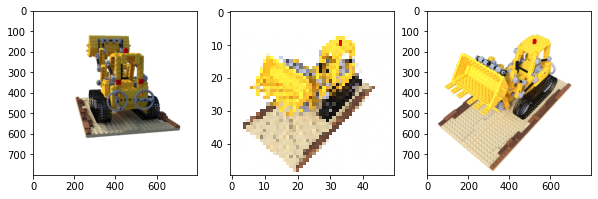

In [27]:
fig2 = plt.figure(figsize=(10,30))
axes2 = fig2.subplots(nrows=1, ncols=3)
axes2[0].imshow(initrgb)
axes2[1].imshow(rgb_sample.detach().cpu().numpy())
axes2[2].imshow(Targetrgb.detach().cpu().numpy())
plt.show

0.05

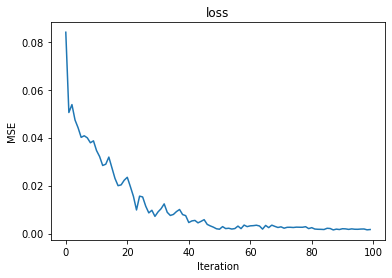

In [28]:
plt.plot(torch.stack(losssave).detach().cpu().numpy())
plt.title("loss")
plt.ylabel("MSE")
plt.xlabel("Iteration")
0.05

In [29]:
one_pose = newpose[:3, :4].detach().cpu().numpy()
tar_pose = Targetpose.detach().cpu().numpy()

def rot2eul(R):
    beta = -np.arcsin(R[2,0])
    alpha = np.arctan2(R[2,1]/np.cos(beta),R[2,2]/np.cos(beta))
    gamma = np.arctan2(R[1,0]/np.cos(beta),R[0,0]/np.cos(beta))
    return (alpha, beta, gamma)

b, a, g = rot2eul(one_pose[:3, :3])
b2, a2, g2 = rot2eul(tar_pose[:3, :3])

print("alpha error :", abs(b-b2)*180/np.pi)
print("beta error :",abs(a-a2)*180/np.pi)
print("gamma error :",abs(g-g2)*180/np.pi)
print("translation error :",abs(np.linalg.norm(one_pose[:3,-1]-tar_pose[:3,-1])))

alpha error : 0.1427031423290764
beta error : 0.1275049975902328
gamma error : 0.09699893149793608
translation error : 0.013446225


In [30]:
saved_loss_new = torch.stack(saved_loss)
fig9 = plt.figure(figsize=(15,5))

axes9 = fig9.subplots(nrows=1, ncols=2)

axes9[0].plot(range(10), saved_loss_new.detach().cpu().numpy(), label='loss')
axes9[0].set(title='last loss', xlabel='Experiments', ylabel='MSE')
axes9[0].plot(range(10), np.mean(saved_loss_new.detach().cpu().numpy())*np.ones(10), label='average')
axes9[0].legend()

axes9[1].plot(range(10), saved_time, label='loss')
axes9[1].plot(range(10), np.mean(saved_time)*np.ones(10), label='average')
axes9[1].set(title='time', xlabel='Experiments', ylabel='sec')
axes9[0].legend()
plt.show

NameError: name 'saved_loss' is not defined

# Video generation

In [157]:
import glob
import cv2
import re

# renderpath = "./iNeRFrender11_trivial"
imglist = glob.glob(os.path.join(renderpath, "*.jpg"))
convert = lambda text: float(text) if text.isdigit() else text
alphanum = lambda key: [convert(c) for c in re.split('([-+]?[0-9]*)', key)]
imglist.sort(key=alphanum)

img = cv2.imread(imglist[0], cv2.IMREAD_COLOR)
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
fps = 10.0

# catimg = np.concatenate((cv2.cvtColor((255.*cv2.resize(initrgb, dsize=(img.shape[0], img.shape[1]), interpolation=cv2.INTER_AREA)).astype('uint8'), cv2.COLOR_RGB2BGR),
#                 img,
#                 cv2.cvtColor((255.*cv2.resize(Targetrgb.detach().cpu().numpy(), dsize=(img.shape[0], img.shape[1]), interpolation=cv2.INTER_AREA)).astype('uint8'), cv2.COLOR_RGB2BGR)), axis=1)

out = cv2.VideoWriter(os.path.join(renderpath, "video.mp4"), fourcc, fps, (3*img.shape[1], img.shape[0]))

for i in range(len(imglist)):
    img = cv2.imread(imglist[i], cv2.IMREAD_COLOR)
    catimg = np.concatenate((cv2.cvtColor((255.*cv2.resize(initrgb, dsize=(img.shape[0], img.shape[1]), interpolation=cv2.INTER_AREA)).astype('uint8'), cv2.COLOR_RGB2BGR),
                img,
                cv2.cvtColor((255.*cv2.resize(Targetrgb.detach().cpu().numpy(), dsize=(img.shape[0], img.shape[1]), interpolation=cv2.INTER_AREA)).astype('uint8'), cv2.COLOR_RGB2BGR)), axis=1)
    out.write(catimg)

out.release()
# cv2.destroyAllWindows()



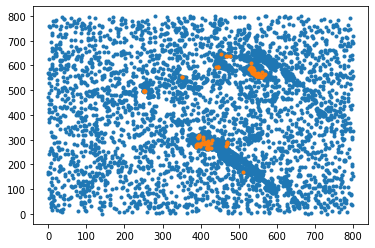

In [26]:
plt.scatter(Hidx.detach().cpu().numpy(),Widx.detach().cpu().numpy(),marker='.')
plt.scatter(Hidx[bestidx[:1000]].detach().cpu().numpy(),Widx[bestidx[:1000]].detach().cpu().numpy(),marker='.')